# Needed for consistently measuring RVs.
To consistently measure the RVs of my target stars, I need to align them with the telluric lines. That is because I took no effort to make sure they are consistent by e.g. observing an RV standard or something. I have a decent amount of code already written for the IGRINS pipeline, so lets just re-use that.

## Status as of end of day Thusday, Sep 3:
  - Seems to work. Need to go through and apply to all of my stars I guess?
  - How stable is the rv fit?
  - Is it the same for all echi files that go into the final ones?
  - Need to keep track of the velocity changes to include in the companion velocities (or just re-run the ccf analysis on the new files)

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import HelperFunctions
import telfit
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import FittingUtilities
from scipy.optimize import minimize
from functools import partial
import Telluric_Wavecal
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
home = os.environ['HOME']
#sys.path.append('{}/School/Research/IGRINS_data/plp/recipes/'.format(home))
#import recipe_tell_wvsol

%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
with open('../starlist_20151013', 'r') as f:
    fnames = ['../{}'.format(fn).strip() for fn in f.readlines()]

In [3]:
fname = fnames[-1]
reload(Telluric_Wavecal)
o2_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(690, ))
h2o_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(700., 715., 730.))

print('O2 Fit:\n================')
o2_rv, o2_rv_err = o2_fitter.fit()
print('\n\nH2O Fit:\n===============')
h2o_rv, h2o_rv_err = h2o_fitter.fit()

Warning, 139 of 94568 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.059





H2O Fit:

INFO:root:RV = -0.36 +/- 0.070


(690.47, 690.55)

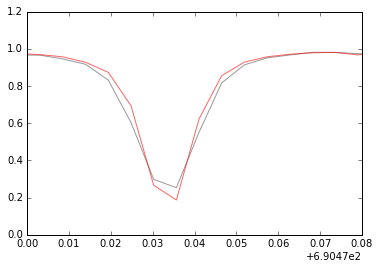

In [4]:
data = o2_fitter.data['KG15164-0.fits']
pars = o2_fitter._fit_one_file(data, )
rv = pars['rv'].value
alpha = pars['alpha'].value

telluric = partial(o2_fitter.new_telluric, o2_fitter.telluric_model, alpha)

%matplotlib inline
for order in data:
    x = order.x*(1+rv/Telluric_Wavecal.C_LIGHT)
    plt.plot(order.x, order.y/order.cont, 'k-', alpha=0.4)
    plt.plot(order.x, telluric(x), 'r-', alpha=0.6)
#plt.xlim((690.35, 690.6))
plt.xlim((690.47, 690.55))

(720.6, 720.7)

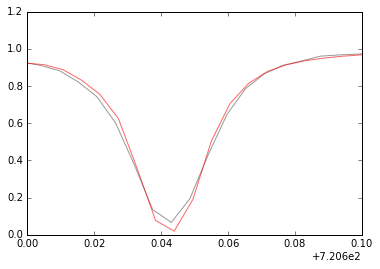

In [10]:
data = h2o_fitter.data['KG15164-0.fits']
pars = h2o_fitter._fit_one_file(data, )
rv = pars['rv'].value
alpha = pars['alpha'].value

telluric = partial(h2o_fitter.new_telluric, h2o_fitter.telluric_model, alpha)

%matplotlib inline
for order in data:
    x = order.x#*(1+rv/Telluric_Wavecal.C_LIGHT)
    plt.plot(order.x*(1+rv/Telluric_Wavecal.C_LIGHT), order.y/order.cont, 'k-', alpha=0.4)
    plt.plot(order.x, telluric(x), 'r-', alpha=0.6)
plt.xlim((720.6, 720.7))

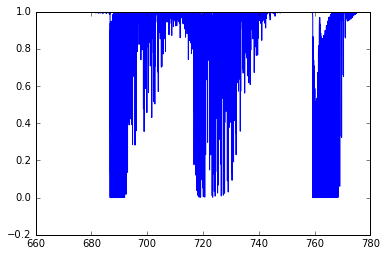

In [30]:
import telfit
modeler = telfit.Modeler()
full_model = modeler.MakeModel(highfreq=1e7/680.0, lowfreq=1e7/780.0)
plt.plot(full_model.x, full_model.y)

In [33]:
with open('telluric_wavecal_summary.csv', 'w') as f:
    f.write('filename,o2_rv,o2_rv_err,h2o_rv,h2o_rv_err\n')

for i, fname in enumerate(fnames):
    print('File {}/{}: {}'.format(i+1, len(fnames), fname))
    o2_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(690.,), telluric_model=full_model)
    h2o_fitter = Telluric_Wavecal.VelocityFitter(fname, tell_orders=(700., 715., 730.), telluric_model=full_model)
    
    print('O2 Fit:\n================')
    o2_rv, o2_rv_err = o2_fitter.fit()
    print('\n\nH2O Fit:\n===============')
    h2o_rv, h2o_rv_err = h2o_fitter.fit()
    
    with open('telluric_wavecal_summary.csv', 'a') as f:
        f.write('{},{},{},{},{}\n'.format(fname, o2_rv, o2_rv_err, h2o_rv, h2o_rv_err))

File 1/120: ../20130106/HIP_28691.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.81 +/- 0.259





H2O Fit:

INFO:root:RV = -0.56 +/- 0.172



File 2/120: ../20130107/HIP_16147.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.37 +/- 0.031





H2O Fit:

INFO:root:RV = -0.10 +/- 0.026



File 3/120: ../20130107/HIP_18724.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.32 +/- 0.140





H2O Fit:

INFO:root:RV = -0.24 +/- 0.089



File 4/120: ../20130107/HIP_25048.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.58 +/- 0.061





H2O Fit:

INFO:root:RV = -0.35 +/- 0.061



File 5/120: ../20130107/HIP_25281.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.132





H2O Fit:

INFO:root:RV = -0.59 +/- 0.061



File 6/120: ../20130107/HIP_3300.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.06 +/- 0.291





H2O Fit:

INFO:root:RV = -0.07 +/- 0.139



File 7/120: ../20130107/HIP_45688.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.63 +/- 0.124





H2O Fit:

INFO:root:RV = -0.44 +/- 0.046



File 8/120: ../20130107/HIP_55266.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.72 +/- nan
INFO:root:RV = -0.57 +/- nan





H2O Fit:
File 9/120: ../20130823/HIP_116971.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.31 +/- 0.025





H2O Fit:

INFO:root:RV = -0.15 +/- 0.023



File 10/120: ../20130824/HIP_116805.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.52 +/- 0.116





H2O Fit:

INFO:root:RV = -0.26 +/- 0.102



File 11/120: ../20131017/HIP_101716.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.56 +/- 0.122





H2O Fit:

INFO:root:RV = -0.35 +/- 0.129



File 12/120: ../20131017/HIP_14576.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- 0.132





H2O Fit:

INFO:root:RV = -0.41 +/- 0.117



File 13/120: ../20131017/HIP_15444.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.59 +/- 0.064





H2O Fit:

INFO:root:RV = -0.36 +/- 0.067



File 14/120: ../20131018/HIP_111841.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- 0.039





H2O Fit:

INFO:root:RV = -0.44 +/- 0.039



File 15/120: ../20131018/HIP_116631.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.58 +/- 0.181





H2O Fit:

INFO:root:RV = -0.30 +/- 0.162



File 16/120: ../20131018/HIP_118243.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -1.16 +/- 0.038





H2O Fit:

INFO:root:RV = -0.96 +/- 0.037



File 17/120: ../20131018/HIP_12719.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.76 +/- 0.134





H2O Fit:

INFO:root:RV = -0.46 +/- 0.103



File 18/120: ../20131018/HIP_14576.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.63 +/- 0.100





H2O Fit:

INFO:root:RV = -0.33 +/- 0.079



File 19/120: ../20131018/HIP_16244.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- 0.034





H2O Fit:

INFO:root:RV = -0.32 +/- 0.026



File 20/120: ../20131018/HIP_2912.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.059





H2O Fit:

INFO:root:RV = -0.43 +/- 0.057



File 21/120: ../20131018/HIP_98194.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.62 +/- 0.117





H2O Fit:

INFO:root:RV = -0.37 +/- 0.115



File 22/120: ../20131018/HIP_99080.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.40 +/- 0.097





H2O Fit:

INFO:root:RV = -0.18 +/- 0.098



File 23/120: ../20131019/HIP_106711.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.066





H2O Fit:

INFO:root:RV = -0.33 +/- 0.010



File 24/120: ../20131019/HIP_12706.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.49 +/- 0.082





H2O Fit:

INFO:root:RV = -0.17 +/- 0.033



File 25/120: ../20131019/HIP_97496.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -1.09 +/- 0.066





H2O Fit:

INFO:root:RV = -0.86 +/- 0.066



File 26/120: ../20131020/HIP_105966.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.76 +/- 0.150





H2O Fit:

INFO:root:RV = -0.52 +/- 0.150



File 27/120: ../20131020/HIP_111169.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.58 +/- 0.043





H2O Fit:

INFO:root:RV = -0.30 +/- 0.040



File 28/120: ../20131020/HIP_1366.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.219





H2O Fit:

INFO:root:RV = -0.46 +/- 0.216



File 29/120: ../20131020/HIP_18805.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.94 +/- 0.077





H2O Fit:

INFO:root:RV = -0.66 +/- 0.074



File 30/120: ../20131020/HIP_3881.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.62 +/- 0.069





H2O Fit:

INFO:root:RV = -0.31 +/- 0.073



File 31/120: ../20131020/HIP_4436.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.84 +/- 0.088





H2O Fit:

INFO:root:RV = -0.53 +/- 0.082



File 32/120: ../20131020/HIP_95853.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.58 +/- 0.095





H2O Fit:

INFO:root:RV = -0.33 +/- 0.093



File 33/120: ../20131020/HIP_96288.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.60 +/- 0.090





H2O Fit:

INFO:root:RV = -0.38 +/- 0.089



File 34/120: ../20131020/HR_604.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.081





H2O Fit:

INFO:root:RV = -0.45 +/- 0.078



File 35/120: ../20131021/HIP_109521.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.63 +/- 0.027





H2O Fit:

INFO:root:RV = -0.33 +/- 0.028



File 36/120: ../20131021/HIP_113788.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.056





H2O Fit:

INFO:root:RV = -0.41 +/- 0.055



File 37/120: ../20131021/HIP_117371.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.62 +/- 0.039





H2O Fit:

INFO:root:RV = -0.35 +/- 0.037



File 38/120: ../20131021/HIP_20789.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.89 +/- 0.072





H2O Fit:

INFO:root:RV = -0.58 +/- 0.068



File 39/120: ../20131021/HIP_2505.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.046





H2O Fit:

INFO:root:RV = -0.38 +/- 0.046



File 40/120: ../20131021/HIP_9312.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.64 +/- 0.034





H2O Fit:

INFO:root:RV = -0.34 +/- 0.031



File 41/120: ../20131021/HIP_98055.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = 0.04 +/- 0.057





H2O Fit:

INFO:root:RV = 0.31 +/- 0.055



File 42/120: ../20131021/HR_545.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.78 +/- 0.101





H2O Fit:

INFO:root:RV = -0.48 +/- 0.046



File 43/120: ../20131022/HIP_114520.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.090





H2O Fit:

INFO:root:RV = -0.42 +/- 0.051



File 44/120: ../20131022/HIP_5131.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.130





H2O Fit:

INFO:root:RV = -0.37 +/- 0.147



File 45/120: ../20131022/HIP_5132.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.61 +/- 0.086





H2O Fit:

INFO:root:RV = -0.35 +/- 0.048



File 46/120: ../20131022/HIP_93747.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.091





H2O Fit:

INFO:root:RV = -0.42 +/- 0.062



File 47/120: ../20131022/HIP_98325.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.69 +/- 0.073





H2O Fit:

INFO:root:RV = -0.34 +/- 0.068



File 48/120: ../20131122/HIP_10670.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.076





H2O Fit:

INFO:root:RV = -0.45 +/- 0.086



File 49/120: ../20131122/HIP_106711.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.58 +/- 0.055





H2O Fit:

INFO:root:RV = -0.32 +/- 0.055



File 50/120: ../20131122/HIP_13209.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.099





H2O Fit:

INFO:root:RV = -0.44 +/- 0.103



File 51/120: ../20131122/HIP_13879.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.79 +/- 0.092





H2O Fit:

INFO:root:RV = -0.52 +/- 0.095



File 52/120: ../20131122/HIP_813.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.57 +/- 0.045





H2O Fit:

INFO:root:RV = -0.32 +/- 0.051



File 53/120: ../20140110/HIP_22509.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.66 +/- 0.055





H2O Fit:

INFO:root:RV = -0.41 +/- 0.050



File 54/120: ../20140110/HIP_41307.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.62 +/- 0.075





H2O Fit:

INFO:root:RV = -0.38 +/- 0.078



File 55/120: ../20140111/HIP_19799.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.049





H2O Fit:

INFO:root:RV = -0.41 +/- 0.042



File 56/120: ../20140111/HIP_31278.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- 0.021





H2O Fit:

INFO:root:RV = -0.38 +/- 0.015



File 57/120: ../20140111/HIP_36760.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- nan
INFO:root:RV = -0.37 +/- nan





H2O Fit:
File 58/120: ../20140111/HIP_39567.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.73 +/- 0.050





H2O Fit:

INFO:root:RV = -0.42 +/- 0.043



File 59/120: ../20140111/HIP_70400.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.99 +/- 0.128





H2O Fit:

INFO:root:RV = -0.62 +/- 0.117



File 60/120: ../20140111/HR_545.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- 0.033





H2O Fit:

INFO:root:RV = -0.38 +/- 0.026



File 61/120: ../20140112/HIP_25695.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.092





H2O Fit:

INFO:root:RV = -0.43 +/- 0.071



File 62/120: ../20140112/HIP_3478.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.74 +/- 0.108





H2O Fit:

INFO:root:RV = -0.49 +/- 0.119



File 63/120: ../20140112/HIP_38538.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.72 +/- 0.089





H2O Fit:

INFO:root:RV = -0.42 +/- 0.060



File 64/120: ../20140112/HIP_52638.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.64 +/- 0.118





H2O Fit:

INFO:root:RV = -0.37 +/- 0.118



File 65/120: ../20140112/HIP_56633.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.61 +/- 0.087





H2O Fit:

INFO:root:RV = -0.33 +/- 0.086



File 66/120: ../20140112/HIP_59819.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.80 +/- 0.103





H2O Fit:

INFO:root:RV = -0.49 +/- 0.094



File 67/120: ../20140112/HIP_65477.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.096





H2O Fit:

INFO:root:RV = -0.39 +/- 0.098



File 68/120: ../20140113/HIP_13327.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.82 +/- 0.069





H2O Fit:

INFO:root:RV = -0.53 +/- 0.068



File 69/120: ../20140113/HIP_25555.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.78 +/- 0.040





H2O Fit:

INFO:root:RV = -0.51 +/- 0.050



File 70/120: ../20140113/HIP_36393.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.72 +/- 0.014





H2O Fit:

INFO:root:RV = -0.48 +/- 0.021



File 71/120: ../20140113/HIP_43142.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.80 +/- 0.044





H2O Fit:

INFO:root:RV = -0.53 +/- 0.051



File 72/120: ../20140113/HIP_52911.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.85 +/- 0.132





H2O Fit:

INFO:root:RV = -0.49 +/- 0.091



File 73/120: ../20140113/HIP_54849.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.75 +/- 0.120





H2O Fit:

INFO:root:RV = -0.42 +/- 0.108



File 74/120: ../20140119/HIP_12803.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.84 +/- 0.115





H2O Fit:

INFO:root:RV = -0.53 +/- 0.061



File 75/120: ../20140119/HIP_16210.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- 0.063





H2O Fit:

INFO:root:RV = -0.39 +/- 0.024



File 76/120: ../20140119/HIP_19968.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.64 +/- 0.089





H2O Fit:

INFO:root:RV = -0.34 +/- 0.085



File 77/120: ../20140119/HIP_26093.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -1.01 +/- 0.063





H2O Fit:

INFO:root:RV = -0.65 +/- 0.049



File 78/120: ../20140119/HIP_31434.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.78 +/- 0.108





H2O Fit:

INFO:root:RV = -0.49 +/- 0.027



File 79/120: ../20140119/HIP_36393.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.77 +/- 0.084





H2O Fit:

INFO:root:RV = -0.55 +/- 0.083



File 80/120: ../20140119/HIP_39847.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.081





H2O Fit:

INFO:root:RV = -0.46 +/- 0.021



File 81/120: ../20140119/HIP_47006.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.62 +/- 0.128





H2O Fit:

INFO:root:RV = -0.38 +/- 0.136



File 82/120: ../20140119/HIP_52422.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.84 +/- 0.026





H2O Fit:

INFO:root:RV = -0.56 +/- 0.032



File 83/120: ../20140119/HIP_52457.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.77 +/- 0.064





H2O Fit:

INFO:root:RV = -0.45 +/- 0.056



File 84/120: ../20140119/HIP_56034.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.72 +/- 0.088





H2O Fit:

INFO:root:RV = -0.43 +/- 0.083



File 85/120: ../20140119/HIP_60595.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.43 +/- 0.106





H2O Fit:

INFO:root:RV = -0.23 +/- 0.099



File 86/120: ../20140120/HIP_12332.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.63 +/- 0.082





H2O Fit:

INFO:root:RV = -0.32 +/- 0.083



File 87/120: ../20140120/HIP_21928.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.126





H2O Fit:

INFO:root:RV = -0.32 +/- 0.128



File 88/120: ../20140120/HIP_26563.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- 0.082





H2O Fit:

INFO:root:RV = -0.34 +/- 0.071



File 89/120: ../20140120/HIP_34769.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.083





H2O Fit:

INFO:root:RV = -0.39 +/- 0.080



File 90/120: ../20140120/HIP_44127.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.74 +/- 0.058





H2O Fit:

INFO:root:RV = -0.46 +/- 0.051



File 91/120: ../20140120/HIP_50303.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.107





H2O Fit:

INFO:root:RV = -0.38 +/- 0.123



File 92/120: ../20140120/HIP_51685.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.75 +/- 0.044





H2O Fit:

INFO:root:RV = -0.49 +/- 0.051



File 93/120: ../20140120/HIP_65728.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- 0.054





H2O Fit:

INFO:root:RV = -0.34 +/- 0.045



File 94/120: ../20140121/HIP_16340.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- 0.097





H2O Fit:

INFO:root:RV = -0.30 +/- 0.093



File 95/120: ../20140121/HIP_18141.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.61 +/- 0.045





H2O Fit:

INFO:root:RV = -0.31 +/- 0.044



File 96/120: ../20140121/HIP_22840.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.69 +/- 0.115





H2O Fit:

INFO:root:RV = -0.34 +/- 0.111



File 97/120: ../20140121/HIP_33372.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.77 +/- 0.088





H2O Fit:

INFO:root:RV = -0.34 +/- 0.084



File 98/120: ../20140121/HIP_50860.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.28 +/- 0.267





H2O Fit:

INFO:root:RV = -0.16 +/- 0.230



File 99/120: ../20140121/HIP_60957.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.71 +/- 0.211





H2O Fit:

INFO:root:RV = -0.26 +/- 0.218



File 100/120: ../20140121/HIP_75178.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.51 +/- 0.093





H2O Fit:

INFO:root:RV = -0.15 +/- 0.077



File 101/120: ../20140122/HIP_14764.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.75 +/- 0.106





H2O Fit:

INFO:root:RV = -0.43 +/- 0.111



File 102/120: ../20140122/HIP_21819.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.72 +/- 0.118





H2O Fit:

INFO:root:RV = -0.33 +/- 0.114



File 103/120: ../20140122/HIP_22833.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.057





H2O Fit:

INFO:root:RV = -0.32 +/- 0.056



File 104/120: ../20140122/HIP_29997.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.57 +/- 0.029





H2O Fit:

INFO:root:RV = -0.19 +/- 0.028



File 105/120: ../20140122/HIP_39236.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.60 +/- 0.063





H2O Fit:

INFO:root:RV = -0.23 +/- 0.060



File 106/120: ../20140122/HIP_46225.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.60 +/- 0.133





H2O Fit:

INFO:root:RV = -0.24 +/- 0.119



File 107/120: ../20140123/HIP_35341.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.61 +/- 0.054





H2O Fit:

INFO:root:RV = -0.38 +/- 0.085



File 108/120: ../20140124/HIP_13879.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.67 +/- nan
INFO:root:RV = -0.42 +/- nan





H2O Fit:
File 109/120: ../20140124/HIP_42313.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.82 +/- 0.111





H2O Fit:

INFO:root:RV = -0.55 +/- 0.092



File 110/120: ../20140124/HIP_70327.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.77 +/- nan
INFO:root:RV = -0.50 +/- inf





H2O Fit:
File 111/120: ../20141101/HIP_106786.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.50 +/- 0.013





H2O Fit:

INFO:root:RV = -0.24 +/- 0.009



File 112/120: ../20141101/HIP_109521.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.86 +/- 0.213





H2O Fit:

INFO:root:RV = -0.47 +/- 0.198



File 113/120: ../20141101/HIP_116631.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.84 +/- 0.170





H2O Fit:

INFO:root:RV = -0.46 +/- 0.114



File 114/120: ../20141101/HIP_21589.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.82 +/- 0.033





H2O Fit:

INFO:root:RV = -0.44 +/- 0.022



File 115/120: ../20141101/HIP_21683.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.74 +/- 0.082





H2O Fit:

INFO:root:RV = -0.35 +/- 0.084



File 116/120: ../20141101/HIP_2505.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.81 +/- 0.060





H2O Fit:

INFO:root:RV = -0.40 +/- 0.083



File 117/120: ../20141101/HIP_93225.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.44 +/- 0.097





H2O Fit:

INFO:root:RV = -0.18 +/- 0.097



File 118/120: ../20141102/HIP_17527.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.65 +/- 0.026





H2O Fit:

INFO:root:RV = -0.34 +/- 0.042



File 119/120: ../20141102/HIP_3478.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.77 +/- 0.045





H2O Fit:

INFO:root:RV = -0.45 +/- 0.053



File 120/120: ../20141103/HIP_3881.fits
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
Warning, 1337 of 684208 bins contained negative fluxes; they have been set to zero.
O2 Fit:

INFO:root:RV = -0.68 +/- 0.059





H2O Fit:

INFO:root:RV = -0.36 +/- 0.070


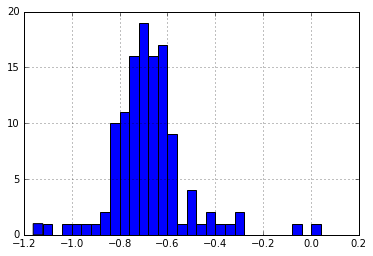

In [34]:
import pandas as pd
df = pd.read_csv('telluric_wavecal_summary.csv')
df.o2_rv.hist(bins=30)

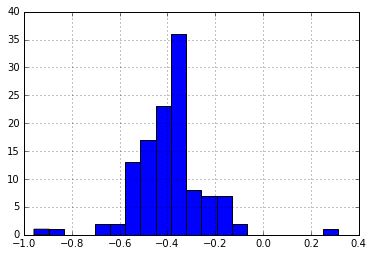

In [35]:
df.h2o_rv.hist(bins=20)

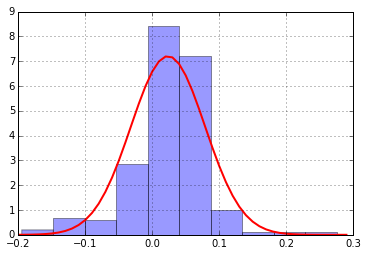

In [25]:
import scipy.stats
values = df.h2o_rv
loc, scale = scipy.stats.norm.fit(data=values[~np.isnan(values)])
df.h2o_rv.hist(bins=10, normed=True, alpha=0.4)
x = np.arange(-0.2, 0.3, 0.01)
y = scipy.stats.norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, y, 'r-', lw=2)

55
(683.05213119143082, 694.06829395818613)
(696.99142286661333, 708.23179628605158)
(711.51142568514979, 722.98535037882675)
(726.64920786127971, 738.36661986523609)


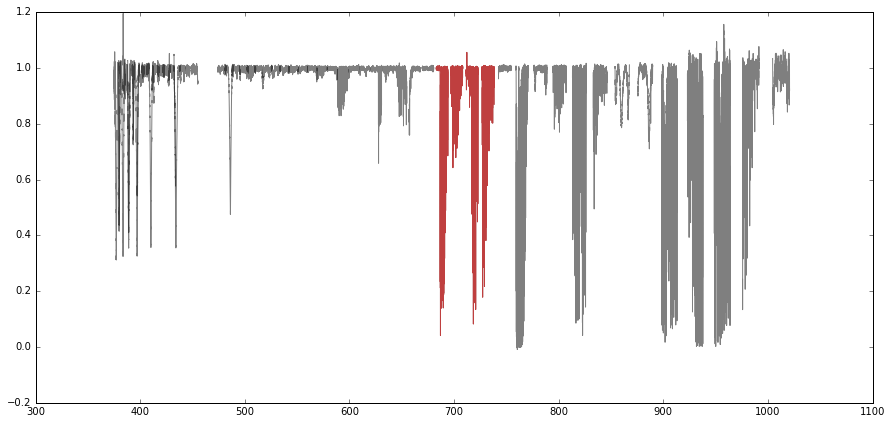

In [26]:
orders = HelperFunctions.ReadExtensionFits('../20140110/KG13385-0.fits')
print(len(orders))
%matplotlib inline
fig = plt.figure(figsize=(15,7))
ordernums = HelperFunctions.FindOrderNums(orders, (690., 700., 715., 730.))

for order in orders:
    plt.plot(order.x, order.y/order.cont, 'k-', alpha=0.5)
    
    
for order in [orders[n] for n in ordernums]:
    plt.plot(order.x, order.y/order.cont, 'r-', alpha=0.5)
    print(order.x[0], order.x[-1])